In [19]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os # for creating directories
import pydot

In [20]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [21]:
state_size = 10*10 #10x10 matrix data, do np.reshape([100])

In [22]:
a1 = np.reshape(np.reshape(np.arange(100), [10,10]), [100])

In [23]:
action_size = 4

In [24]:
batch_size = 32

In [25]:
output_dir = 'model_output/ToyProblem/'


In [26]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [68]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # double-ended queue; acts like list, but elements can be added/removed from either end
        self.gamma = 1 #0.95 # decay or discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate
        self.epsilon = 0.99 # exploration rate: how much to act randomly; more initially than later due to epsilon decay
        self.epsilon_decay = 0.9995 # decrease number of random explorations as the agent's performance (hopefully) improves over time
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted
        self.learning_rate = 0.01 # rate at which NN adjusts models parameters via SGD to reduce cost 
        self.model = self._build_model() # private method 
    
    def _build_model(self):
        # neural net to approximate Q-value function:
        model = Sequential()
        model.add(Dense(10, input_dim=self.state_size, activation='relu')) # 1st hidden layer; states as input
        #model.add(Dense(24, activation='relu')) #add move layers, for CNN
        model.add(Dense(self.action_size, activation='linear')) # 2 actions, so 2 output neurons: 0 and 1 (L/R)
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # list of previous experiences, enabling re-training later

    def act(self, state):
        if np.random.rand() <= self.epsilon: # if acting randomly, take random action
            return random.randrange(self.action_size)
        act_values = self.model.predict(state) # if not acting randomly, predict reward value based on current state
        return np.argmax(act_values[0]) # pick the action that will give the highest reward (i.e., go left or right?)

    def replay(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch: # extract data for each minibatch sample
            target = reward # if done (boolean whether game ended or not, i.e., whether final state or not), then target = reward
            if not done: # if not done, then predict future discounted reward
                target = (reward + self.gamma * # (target) = reward + (discount rate gamma) * 
                          np.amax(self.model.predict(next_state)[0])) # (maximum target Q based on future action a')
            target_f = self.model.predict(state) # approximately map current state to future discounted reward
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0) # single epoch of training with x=state, y=target_f; fit decreases loss btwn target_f and y_hat
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [69]:
agent = DQNAgent(state_size, action_size) # initialise agent 

In [70]:
agent

In [71]:
start_state = np.zeros([10,10])

In [72]:
state = start_state # reset state at start of each new episode of the game
state = np.reshape(state, [1, state_size])


In [73]:
state.shape

(1, 100)

In [74]:
state2D = np.reshape(state, [10,10])
state2D

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [75]:
model = Sequential()
model.add(Dense(5, input_dim=16, activation='relu')) # 1st hidden layer; states as input
model.add(Dense(4, activation='linear')) # 2 actions, so 2 output neurons: 0 and 1 (L/R)
model.compile(loss='mse',
              optimizer=Adam(lr=0.03))
model

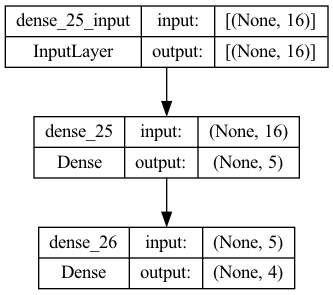

In [76]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [77]:
action = agent.act(state) + 1
action

4

# Toy problem

In [51]:
#setting up actions:

def movef(action, position):
    moved = False
    newposition = position #make the new position the current position, so position does not change if move is invalid
    if action == 1 and position[1] != 9: #right
        newposition = [position[0], position[1]+1]
        moved == True
    if action == 2 and position[0] != 0: #up
        newposition = [position[0]-1, position[1]]
        moved == True
    if action == 3 and position[1] != 0: #left
        newposition = [position[0], position[1]-1]
        moved == True
    if action == 4 and position[0] != 9: #down
        newposition = [position[0] + 1, position[1]]
        moved == True
    return newposition

In [52]:
def RMSreward(real, fit):
    real = np.array(real)
    fit = np.array(fit)
    RMS = np.sqrt(np.average((real - fit)**2))
    reward = 1/(RMS + 0.01)
    return reward

In [53]:
#setting up subsurface model:

M = np.zeros([10,10]) #generate grid of zeros
tlc = [random.randint(0,5),random.randint(0,5)] #top left corner
M[tlc[0]:tlc[0] + 5, tlc[1]:tlc[1] + 5] = 1
M

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.]])

In [78]:
#now for the reward, we do ground truthing, by fitting a 5x5 square to the
#state data, and then determining the misfit

def fitstate(S): #takes in the state
    fit = False

    while(not fit):
        #generate possible fit model:
        fM = np.zeros([10,10]) #fit Model
        ftlc = [random.randint(0,5),random.randint(0,5)] #fit top left corner
        fM[ftlc[0]:ftlc[0] + 5, ftlc[1]:ftlc[1] + 5] = 1

        fit = True #make fit true, but false if fit does not agree with survey
        for i in range(len(fM)):
            for j in range(len(fM[i])):
                if(S[i,j] != 0 and fM[i,j] * 2 - 1 != S[i,j]):
                    fit = False
    return fM

In [79]:
start_state = np.zeros([10,10]) #original state


In [80]:
sp = [0,0] #start at top left corner
p = sp 

state = start_state + 0 # reset state at start of each new episode of the game
state = np.reshape(state, [1, state_size])


In [81]:
start_state

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [82]:
move  = 1
p = movef(move, p)
state2D = np.reshape(state, [10,10])+0
state2D[p[0], p[1]] = M[p[0], p[1]] * 2 - 1
#state = np.reshape(state2D, [1, state_size])
state2D

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [83]:
state

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [84]:
state.shape

(1, 100)

In [85]:
agent = DQNAgent(state_size, action_size) # initialise agent 

/Users/andreyremorov/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [86]:
reward_list = []

In [63]:
state2D_list = []

In [64]:
#need to figure out how to make this learn faster...implement CNN
n_episodes = 1000  # n games we want agent to play (default 1001)
for e in range(n_episodes): # iterate over new episodes of the game
    state = np.zeros([10,10]) # reset state at start of each new episode of the game
    state = np.reshape(state, [1, state_size])
    sp = [5,5]
    p = sp
    
    M = np.zeros([10,10]) #generate random model
    tlc = [5*random.randint(0,1),5*random.randint(0,1)]
    M[tlc[0]:tlc[0] + 5, tlc[1]:tlc[1] + 5] = 1
    
    print(e)
    timesteps = 2
    for time in range(timesteps):  # time represents a frame of the game; goal is to keep pole upright as long as possible up to range, e.g., 500 or 5000 timesteps
#       env.render()
        action = agent.act(state) # action is 0,1,2,3
        p = movef(action+1, p) #make action 1,2,3,4
        state2D = np.reshape(state, [10,10])+0
        state2D[p[0], p[1]] = M[p[0], p[1]] * 2 - 1
        next_state = np.reshape(state2D, [1, state_size]) + 0
        reward = 0
        if(time == timesteps - 1):
            r= 0 
            if(state2D[5,4] != 0):
                r+= 1
            if(state2D[4,4] != 0):
                r+= 1
#             if (state2D[5,4]!= 0):
#                 r+=1
#             if(state2D[5,5]!= 0):
#                 r+=1
            reward = r**3
            #reward = RMSreward(fitstate(state2D), M) 
            reward_list.append(reward)
            state2D_list.append(state2D + 0)
            print(reward)
        
        agent.remember(state, action, reward, next_state, False) # remember the previous timestep's state, actions, reward, etc.        
        state = next_state+0 # set "current state" for upcoming iteration to the current next state        
        
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # train the agent by replaying the experiences of the episode
    if e % 50 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")         

0
0
1
8
2
1
3
0
4
8
5
0
6
0
7
0
8
1
9
0
10
0
11
1
12
0
13
0
14
1
15
8
16
0
1/1 [==============================] - 0s 10ms/step
17
0
1/1 [==============================] - 0s 10ms/step
18
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
19
0
1/1 [==============================] - 0s 10ms/step
20
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
21
0
1/1 [==============================] - 0s 11ms/step
22
0
1/1 [==============================] - 0s 10ms/step
23
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
24
1
1/1 [==============================] - 0s 10ms/step
25
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
26
1
1/1 [==============================] - 0s 10ms/step
27
1
1/1 [==============================] - 0s 11ms/step
28
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
29
1
1/1 [==============================] - 0s 10ms/step
30
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
31
0
1/1 [==============================] - 0s 10ms/step
32
0
1/1 [==============================] - 0s 10ms/step
33
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
34
0
1/1 [==============================] - 0s 10ms/step
35
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
36
0
1/1 [==============================] - 0s 10ms/step
37
1
1/1 [==============================] - 0s 11ms/step
38
8
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
39
1
1/1 [==============================] - 0s 10ms/step
40
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
41
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
42
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
43
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
44
1
1/1 [==============================] - 0s 11ms/step
45
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
46
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step
47
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
48
0
1/1 [==============================] - 0s 11ms/step
49
1
1/1 [==============================] - 0s 11ms/step
50
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
51
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
52
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
53
0
1/1 [==============================] - 0s 10ms/step
54
0
1/1 [==============================] - 0s 10ms/step
55
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
56
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
57
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
58
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
59
8
1/1 [==============================] - 0s 10ms/step
60
1/1 [==============================] - 0s 10ms/step
1


1/1 [==============================] - 0s 10ms/step
61
0
1/1 [==============================] - 0s 10ms/step
62
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
63
0
1/1 [==============================] - 0s 9ms/step
64
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
65
0
1/1 [==============================] - 0s 10ms/step
66
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
67
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
68
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
69
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
70
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
71
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
72
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
73
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
74
1
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
75
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
76
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 9ms/step
77
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
78
1
1/1 [==============================] - 0s 10ms/step
79
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
80
0
1/1 [==============================] - 0s 10ms/step
81
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
82
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step
83
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 9ms/step
84
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
85
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
86
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
87
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
88
1
1/1 [==============================] - 0s 10ms/step
89
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
90
0
1/1 [==============================] - 0s 10ms/step
91
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
92
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
93
0
1/1 [==============================] - 0s 10ms/step
94
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
95
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
96
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
97
0
1/1 [==============================] - 0s 10ms/step
98
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
99
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step
100
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
101
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
102
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
103
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
104
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
105
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step
106
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
107
0
1/1 [==============================] - 0s 12ms/step
108
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
109
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
110
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 14ms/step
111
1/1 [==============================] - 0s 12ms/step


1
1/1 [==============================] - 0s 10ms/step
112
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
113
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
114
0
1/1 [==============================] - 0s 10ms/step
115
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
116
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
117
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
118
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
119
1
1/1 [==============================] - 0s 10ms/step
120
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
121
0
1/1 [==============================] - 0s 10ms/step
122
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
123
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
124
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
125
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
126
0
1/1 [==============================] - 0s 10ms/step
127
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
128
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
129
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
130
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
131
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
132
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
133
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step
134
0
1/1 [==============================] - 0s 10ms/step
135
1/1 [==============================] - 0s 12ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
136
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
137
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
138
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
139
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
140
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
141
1
1/1 [==============================] - 0s 12ms/step
142
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
143
1
1/1 [==============================] - 0s 10ms/step
144
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
145
0
1/1 [==============================] - 0s 10ms/step
146
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 13ms/step
147
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
148
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
149
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
150
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 13ms/step
151
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
152
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
153
1/1 [==============================] - 0s 11ms/step
8
1/1 [==============================] - 0s 10ms/step
154
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
155
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
156
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
157
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
158
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
159
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
160
0
1/1 [==============================] - 0s 10ms/step
161
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
162
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
163
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
164
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
165
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
166
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
167
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
168
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
169
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
170
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
171
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
172
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step
173
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
174
1/1 [==============================] - 0s 12ms/step
8
1/1 [==============================] - 0s 10ms/step
175
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
176
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
177
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
178
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
179
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
180
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
181


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
182
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
183
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
184
1
1/1 [==============================] - 0s 10ms/step
185
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
186
0
1/1 [==============================] - 0s 10ms/step
187
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
188
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
189
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
190
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
191
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
192
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
193


1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
194
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 12ms/step
195
8
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
196
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
197
0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
198
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
199
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 13ms/step
200
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
201
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step
202
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
203
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
204
0
1/1 [==============================] - 0s 10ms/step
205
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
206
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
207
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
208
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
209
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
210
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
211
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
212
0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
213
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
214
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
215
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
216
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 11ms/step
217
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
218
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
219
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
220
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
221
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
222
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
223
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
224
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
225
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 9ms/step
226
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
227
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step
228
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
229
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
230
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
231
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
232
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
233
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
234
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
235
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
236
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
237
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
238
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
239
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
240
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 14ms/step
241
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
242
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
243
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
244
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
245
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
246
1
1/1 [==============================] - 0s 10ms/step
247
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
248
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
249
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
250
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
251
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step
252
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
253
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
254
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
255
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
256
1
1/1 [==============================] - 0s 10ms/step
257
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
258
0
1/1 [==============================] - 0s 10ms/step
259
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
260
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
261
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
262
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
263
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
264
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
265
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
266
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
267
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
268
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
269
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
270
0
1/1 [==============================] - 0s 10ms/step
271
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
272
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
273
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
274
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
275
0
1/1 [==============================] - 0s 12ms/step
276
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 12ms/step
277
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
278
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
279
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
280
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step
281
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
282
1/1 [==============================] - 0s 10ms/step
1


1/1 [==============================] - 0s 10ms/step
283
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 11ms/step
284
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
285
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step
286
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
287
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
288
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 13ms/step
289
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
290
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
291
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
292
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
293
0
1/1 [==============================] - 0s 11ms/step
294
1/1 [==============================] - 0s 11ms/step
8
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
295
0
1/1 [==============================] - 0s 13ms/step
296
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
297
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
298
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
299
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
300
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
301
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
302
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
303
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
304
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step
305
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
306
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
307
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
308
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
309
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
310
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
311
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
312
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
313
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
314
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 13ms/step
315
0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
316
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
317
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
318


1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
319
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
320
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
321
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
322
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
323
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
324
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
325
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
326
0
1/1 [==============================] - 0s 10ms/step
327
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
328
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
329
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
330
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step
331
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
332
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
333
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
334
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
335
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
336
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
337
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
338
1/1 [==============================] - 0s 9ms/step
8
1/1 [==============================] - 0s 10ms/step
339
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
340
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 11ms/step
341
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
342
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
343
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
344
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
345
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
346
1/1 [==============================] - 0s 14ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
347
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
348
1/1 [==============================] - 0s 14ms/step
1
1/1 [==============================] - 0s 12ms/step
349
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
350
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step
351
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
352
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
353
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
354
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
355
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
356
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
357
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step
358
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
359
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
360
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 11ms/step
361
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
362
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
363
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
364
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
365
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
366
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
367
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
368
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
369
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
370
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
371
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
372
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
373


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
374
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
375
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
376
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
377
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
378
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
379
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step
380
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
381
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
382
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
383
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
384
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
385
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
386
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
387
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
388
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
389
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
390
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
391
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
392
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
393
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
394
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
395
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
396
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
397
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
398
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
399
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
400
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
401
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
402
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
403
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 12ms/step
404
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
405
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
406
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
407
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
408
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
409
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
410
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
411
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
412
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
413
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
414
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
415
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
416
1/1 [==============================] - 0s 10ms/step
1


1/1 [==============================] - 0s 10ms/step
417
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
418
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
419
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step
420
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
421
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
422
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
423
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
424
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
425
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
426
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
427
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
428
1/1 [==============================] - 0s 10ms/step
1


1/1 [==============================] - 0s 10ms/step
429
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
430
0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
431
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
432
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
433
1/1 [==============================] - 0s 10ms/step
8
1/1 [==============================] - 0s 10ms/step
434
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
435
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
436
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step
437
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
438
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
439
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
440
1/1 [==============================] - 0s 10ms/step


1
1/1 [==============================] - 0s 9ms/step
441
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
442
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
443
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
444
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
445
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
446
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
447
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
448
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
449
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
450
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
451
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
452
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
453
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
454
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
455
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
456
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
457
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
458
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
459
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
460
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
461
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
462
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 13ms/step
463
1/1 [==============================] - 0s 18ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
464
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
465
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
466
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
467
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
468
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
469
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
470
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
471
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
472
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
473
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
474
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
475
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
476
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
477
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
478
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
479
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
480
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
481
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
482
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
483
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
484
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
485
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
486
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
487
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
488
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
489
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
490
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
491
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
492
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
493
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
494
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
495
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
496
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
497
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
498
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
499
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
500
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
501
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
502
1/1 [==============================] - 0s 11ms/step
0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
503
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
504
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
505
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
506
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
507
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
508
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
509
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
510
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
511
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
512
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
513
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
514


1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
515
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
516
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
517
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
518
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step
519
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
520
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
521
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
522
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
523
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
524
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
525
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
526
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
527
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 9ms/step
528
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
529
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
530
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
531
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
532
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
533
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
534
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
535
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
536
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
537
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
538
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
539
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
540
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
541
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
542
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
543
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
544
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
545
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
546
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
547
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
548
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
549
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
550
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
551
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
552
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
553
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
554
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
555
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
556
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
557
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
558
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
559
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
560
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
561
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
562
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
563
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
564
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
565
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
566
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
567
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
568
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
569
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
570
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
571
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
572
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
573
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
574
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
575
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
576
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
577
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
578
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
579
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
580
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
581
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
582
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
583
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
584
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
585
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
586
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step
587
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
588
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
589
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
590
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
591
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
592
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
593
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
594
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
595
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
596
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
597
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
598
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
599
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
600
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
601
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
602
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
603
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
604
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
605
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
606
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
607
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
608
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
609
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
610
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
611
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
612
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
613
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
614
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
615
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
616
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
617
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
618
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
619
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
620
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
621
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
622
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
623
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
624
1
1/1 [==============================] - 0s 10ms/step
625
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
626
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
627
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
628
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
629
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
630
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
631
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
632
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
633
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
634
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
635
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
636
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
637
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
638
1/1 [==============================] - 0s 10ms/step
0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
639
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
640
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
641
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
642
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
643
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
644
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
645
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
646
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
647
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
648
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
649
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
650
1/1 [==============================] - 0s 17ms/step
1


1/1 [==============================] - 0s 10ms/step
651
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step
652
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step
653
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
654
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
655
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
656
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
657
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
658
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
659
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
660
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
661
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
662
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
663
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
664
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
665
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
666
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
667
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
668
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
669
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
670
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
671
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
672
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
673
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
674
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
675
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
676
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
677
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
678
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
679
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
680
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
681


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
682
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
683
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
684
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
685
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
686
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
687
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
688
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
689
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
690
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
691
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
692
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
693
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
694
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
695
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
696
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
697
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
698
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
699
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
700
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
701
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
702
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
703
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
704
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
705
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
706
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
707
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
708
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
709
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
710
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
711
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
712
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
713
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
714
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
715
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
716
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
717
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
718
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
719
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
720
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
721
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
722
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
723
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
724
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
725
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
726
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
727
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 13ms/step
728
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
729
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
730
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
731
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
732
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
733
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
734
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
735
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
736
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
737
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
738
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
739
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
740
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
741
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
742
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
743
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
744
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
745
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
746
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
747
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
748
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
749
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
750
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
751
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
752
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
753
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
754
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
755
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
756
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
757
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
758
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
759
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
760
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
761
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
762
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
763
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
764
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
765
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
766
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
767
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
768
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
769
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
770
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
771
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
772
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
773
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
774
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
775
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
776
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
777
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
778
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
779
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
780
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 9ms/step
781
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
782
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
783
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
784
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
785
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
786
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
787
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
788
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
789
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
790
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
791
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
792
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
793
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
794
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
795
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
796
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
797
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step
798
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
799
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 15ms/step
800
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
801
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
802
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
803
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
804
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
805
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
806
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
807
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
808
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
809
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
810
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
811
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
812
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
813
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
814
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
815
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
816
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
817
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
818
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
819
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
820
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
821
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
822
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
823
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
824
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
825
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
826
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
827
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
828
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
829
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
830
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step
831


1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step
832
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
833
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
834
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
835
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
836
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
837
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
838
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
839
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
840
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
841
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
842
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
843
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
844
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
845
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
846
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
847
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
848
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 10ms/step
849
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
850
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 20ms/step
851
1/1 [==============================] - 0s 15ms/step
1
1/1 [==============================] - 0s 10ms/step
852
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
853
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
854
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
855
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 9ms/step
856
1/1 [==============================] - 0s 9ms/step
1
1/1 [==============================] - 0s 11ms/step
857
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
858
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
859
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
860
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
861
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
862
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
863
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
864
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
865
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
866
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
867
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
868
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step
869
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
870
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 12ms/step
871
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
872
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 10ms/step
873
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
874
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
875
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
876
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
877
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
878
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
879
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 10ms/step
880
1/1 [==============================] - 0s 13ms/step
1
1/1 [==============================] - 0s 10ms/step
881
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
882
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
883
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
884
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step
885
1/1 [==============================] - 0s 12ms/step
1
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
886
1/1 [==============================] - 0s 11ms/step
1
1/1 [==============================] - 0s 11ms/step
887
1/1 [==============================] - 0s 10ms/step
1
1/1 [==============================] - 0s 11ms/step


KeyboardInterrupt: 

In [300]:
e

314

In [301]:
state2D

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [302]:
state2D[5,4]

0.0

In [303]:
reward_list[4]

1

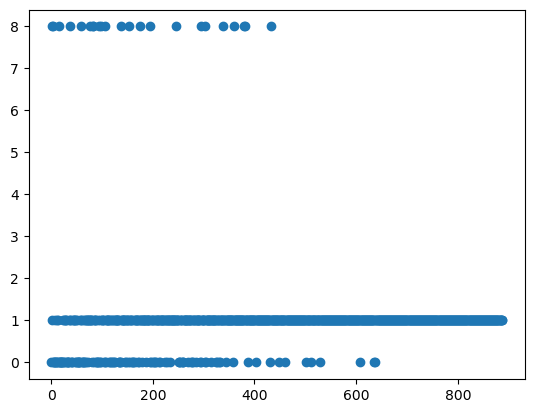

In [66]:
plt.scatter(np.arange(len(reward_list)), reward_list)

In [305]:
state2D_list[4]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])